In [1]:
import pandas as pd
import os
from math import *
import re
from datetime import datetime, date, time, timedelta
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from MPT_utils import * 
import cvxpy as cvx
import numpy as np
from scipy import stats


In [2]:
#universe = ['spy','ark'] 
universe = ['spy']
#universe = ['ark']

#variables for data download
hist_window = 100 #for historical pricing
date_fmt = '%Y-%m-%d'
start_date = datetime.now() - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5
lb = 55; min_gross=0.5; max_gross=1; min_w=0; max_w=0.05 # default optimization vars
refresh_pricing = False
min_weight=-0.01 ## minimo peso para portafolio filtrado 

config = {'spy' : {
            'benchmark': 'spy',
            'skiprows': 1,
            'columns': ['Symbol', 'Company Name']},
        'ark' : {
            'benchmark': 'ark' ,
            'skiprows': 0,
            'columns': ['ticker','company']}}

pricing_path = "./pricing/"
component_path = "./sector_components/"

In [3]:
# 1. Sector Components

# In[3]:

### 1. Sector components:
# de donde se extrae esta info, con que frecuencia se actualiza?

## 1.1 descargar componentes del server:

## 1.2 cargar los sector componentes para cada benchmark, cargar cada ETF sector para cada benchmark
# y cada company para cada ETF sectior y limpiarlos

companies_universe= pd.DataFrame({}) ### contiene todas las compañias del etf sector para cada benchmark
sector_etf = {}   ### contiene cada etf sector para cada benchmark
ticker_map= {}    ### contiene todas las compañias para cada etf sector 

for k in universe:
    #print(config[k])
    companies,benchmark_etf_map,sector_tickers_map=load_companies(benchmark=config[k]['benchmark'],skiprows=config[k]['skiprows'],columns=config[k]['columns']) ## companies del benchmark spy
    print("Companies loaded:",config[k]['benchmark'], companies.shape)
    companies_universe=companies_universe.append(companies)
    sector_etf.update(benchmark_etf_map)
    ticker_map.update(sector_tickers_map)


loaded: xlb
loaded: xle
loaded: xlf
loaded: xli
loaded: xlk
loaded: xlp
loaded: xlre
loaded: xlu
loaded: xlv
loaded: xly
Companies loaded: spy (505, 3)


In [4]:
# 2. Pricing            : Contiene la informacion historica de precios de cada uno de los componentes

## 2.1 descargar componentes del server:

if refresh_pricing==True:
    ### refresh components
    etfs=[ [i,j,ticker_map[j]] for i in universe for j in sector_etf[i] ]
    for i in etfs:
        get_pricing(output_name=pricing_path+i[0]+"/"+i[1]+"-hold-pricing.csv",
        ticker_list=i[2],start_date=start_date)
    ## refresh etf sectors 
    sectors=[[i,sector_etf[i]] for i in universe]
    for j in sectors:
        get_pricing(output_name=pricing_path+j[0]+"/"+j[0]+'-sectors.csv', 
        ticker_list=j[1], start_date=start_date)
    # refresh benchmarks
    benchmarks=[i for i in universe]
    #benchmarks
    for j in benchmarks:
        print(j)
        get_pricing(output_name=pricing_path+ j +'/'+j+'.csv', ticker_list=j, start_date=start_date)


In [5]:

### consol_px contiene los precios historicos de cada compañia
consol_px=load_consol_px(universe)
consol_px=consol_px[sorted(consol_px.columns.tolist())]
print("consol_px"+str(consol_px.shape))
### crear consol_px 

    
# #### Limpiar las compañias que tienen valores nulos en los ultimos 3 dias y valores nulos en toda su serie
consol_px,cols=clean_nas(consol_px) ## limpia de aquellos valores que no tienen valores en su serie o que por alguna razon tienen NAN en los ultimos dias
print("se limpio consol_px"+str(consol_px.shape))
print("se borraron:")
print(cols)


# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)

consol_px.to_csv("consol_mpt_opt.csv")
print("consol_px final: "+str(consol_px.shape))

spy
consol_px(69, 505)
se limpio consol_px(69, 501)
se borraron:
SNI       6
BF.B     69
BRK.B    69
BKNG     55
dtype: int64
consol_px final: (69, 495)


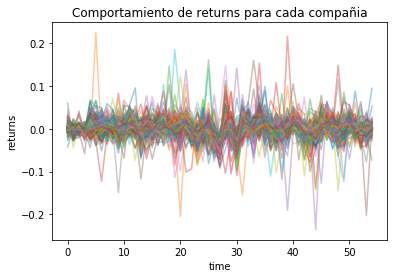

In [6]:
# 3. Optimizacion

px_portion = consol_px[-abs(hist_window):].copy() ## tomar los ultimos hist_window rows de la tabla de precios
px_portion= px_portion.sort_index().pct_change(); px_portion.iloc[0] = 0 ## calcular returns
return_vec =px_portion.loc[:px_portion.tail(1).index[0]].tail(lb)#.dropna()

### grafico de comportamientos de returns
plot_returns(return_vec)


In [7]:

weights =np.asarray([1/len(return_vec.columns) for _ in range(len(return_vec.columns))])
mu = return_vec.mean().values ## vector de return mean
n = len(mu) ## numero de compañias
name = return_vec.mean().index.values.tolist() ## nombre de las compañias
Sigma =  return_vec.cov().values  ## covarianza de los retornos

w = cvx.Variable(n) ## variable a optimizar
gamma = cvx.Parameter(sign='positive') ## aversion al riesgo
ret = mu.T*w   # returns
risk = cvx.quad_form(w, Sigma)
# Portfolio optimization with leverage limit.
prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
               [cvx.sum_entries(w) == 1,  ## problema con exposicion de a los mas 1.5
                cvx.norm(w, 1) <= 1.5,w<.05,w>-.05])


SAMPLES = 100
w_ = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
sharpe = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value=gamma_vals[i]
    prob.solve()
    if prob.status == 'optimal':
        risk_data[i] = sqrt(risk.value)
        ret_data[i]= ret.value
        w_.append([j[0] for j in w.value.tolist()])
        sharpe[i]=ret.value/sqrt(risk.value)


optimo = sharpe.argmax()

In [8]:
sum(w_[optimo])

sum([j for j in w_[optimo] if j<0])
print("Portafolio completo")
print("L max es : "+ str(sum([j for j in w_[optimo] if j>0])))
print("long:"+str(sum([j for j in w_[optimo] if j>0])))
print("short:"+str(sum([j for j in w_[optimo] if j<0])))

Portafolio completo
L max es : 1.2499999998573599
long:1.2499999998573599
short:-0.24999999985736032


In [9]:
## escoger subportafolio
short_position=[j for j in w_[optimo] if j<-.01]
short_position=[j for j in short_position if j>-.05]
sum([j for j in w_[optimo] if j<0])
sum(short_position)
print("short de subportafolio:"+str(sum(short_position)))
long_position=[j for j in w_[optimo] if j>.01]
long_position=[j for j in long_position if j<.05]
sum([j for j in w_[optimo] if j>0])
sum(long_position)
print("long de subportafolio:"+str(sum(long_position)))
weights_all=short_position+long_position

short_names=[w_[optimo].index(j) for j in short_position]
long_names=[w_[optimo].index(j) for j in long_position]

short_names=[name[i] for i in short_names]
long_names=[name[i] for i in long_names]


all_positions=short_names+long_names

short de subportafolio:-0.2314056499009767
long de subportafolio:1.2378392251693655


In [10]:
## calcular las metricas de risk , return y sharpe
returns_subport = px_portion[all_positions]
mu_subportfolio = returns_subport.mean()
cov_matrix_subportfolio = returns_subport.cov()
weights_subportfolio = np.array(weights_all).reshape(len(weights_all),1)
n_dias = returns_subport.shape[0]
return_subportfolio = (np.dot(mu_subportfolio.values, weights_subportfolio)*n_dias)
print("return: "+str(return_subportfolio[0]))
risk_subportfolio = (np.sqrt(np.dot(weights_subportfolio.T, np.dot(cov_matrix_subportfolio.values, weights_subportfolio))))*(np.sqrt(n_dias))
print("risk: "+str(risk_subportfolio[0][0]))
sharpe_subportfolio = return_subportfolio/risk_subportfolio
print("sharpe: "+str(sharpe_subportfolio[0][0]))


return: 0.267529981543
risk: 0.0583399094047
sharpe: 4.58571129563


In [11]:
recommend =pd.DataFrame(weights_all,index=all_positions,columns=["w"]) ### formar portafolio
stats.describe(weights_all)

DescribeResult(nobs=38, minmax=(-0.049999999986283586, 0.049999999999115641), mean=0.026485094086010238, variance=0.0010239400960945658, skewness=-1.2298998576908804, kurtosis=0.24937863895707313)

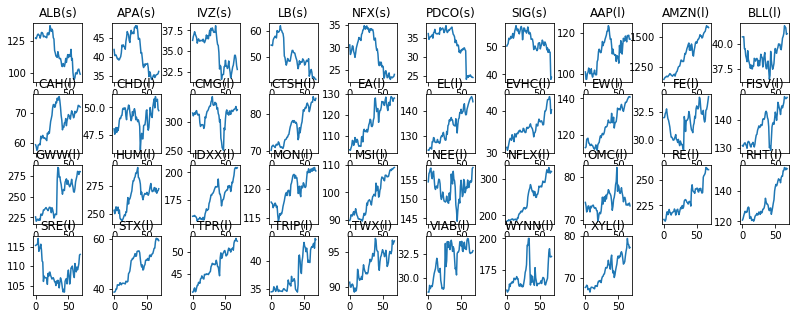

In [12]:
j=1
n=ceil(len(recommend.index.tolist())/4)
plt_all=recommend.index.tolist()
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(left=0.2, wspace=0.6)
for i in plt_all:
    ax=fig.add_subplot(4,n,j) 
    if recommend.loc[i][0]>0:
        p="(l)"
    else:
        p="(s)"
    ax.set_title(i+p)
    ax.plot(consol_px[i].values)
    j=j+1
    #print(i)

plt.show()

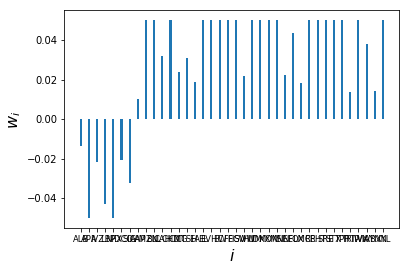

In [13]:
plt.bar( range(len(plt_all)),recommend["w"].tolist(), width = 0.25)
#plt.xticks(recommend.index.tolist())
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xticks(range(len(recommend.index.tolist())), recommend.index.tolist(), size='small')
# Set ticks labels for x-axis
plt.show()

In [14]:

# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = pd.to_datetime(px[-1:].index[0])#.strftime(date_fmt)

trading_cols = ['Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=recommend.index, columns=trading_cols)

port_bal = 231000; 
alloc = recommend["w"].values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
#shares.apply(lambda x: round(x, 6)).T.sort_index()

#trading_df['Company'] = pd.DataFrame(recommend.index)
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['w']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, -.05, .05))
print("Ann. Ret: {1:.3f}, Risk: {1:.3f} Sharpe: {2:.3f}".format(return_subportfolio[0], risk_subportfolio[0][0], sharpe_subportfolio[0][0]))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))

#trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

Time Window: 100, Lookback: 55, MinGross: 0.5, MaxGross: 1, MinWeight: -0.05, MaxWeight: 0.05
Ann. Ret: 0.058, Risk: 0.058 Sharpe: 4.586
Date: 2018-03-15 00:00:00, Total Invested: 232486.16, Total Allocation: 100.64%


,Price,Allocation,Dollar Value,Shares
AAP,117.050003,0.010392,2400.567410,20.508905
ALB,98.849998,-0.013399,-3095.241928,-31.312514
AMZN,1581.880005,0.050000,11550.000000,7.301439
APA,36.229900,-0.050000,-11549.999997,-318.797457
BLL,41.000000,0.050000,11549.999997,281.707317
CAH,71.800003,0.032064,7406.708155,103.157491
CHD,49.709999,0.050000,11549.999999,232.347621
CMG,321.160004,0.023969,5536.767271,17.239903
CTSH,84.230003,0.030971,7154.244468,84.937008
EA,128.130005,0.018644,4306.865988,33.613251
